In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../")
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [4]:
# Perform single run for quick analysis
# results = nnexp.runExperiment_measureIntegrationMNIST(useNet='CNN2P2',DEVICE=None,iterations=5,learningRate=5e-2,dataPath=dataPath)
results = nnexp.runExperiment_measureIntegrationMNIST(useNet='MLP4',DEVICE=None,iterations=20,learningRate=5e-2,ojaAlpha=0,pDropout=0.5)

Initiating experiment using cuda
Loss in epoch   0: 2.225, Accuracy: 20.30%.
Loss in epoch   1: 1.819, Accuracy: 39.50%.
Loss in epoch   2: 1.328, Accuracy: 53.40%.
Loss in epoch   3: 1.184, Accuracy: 59.40%.
Loss in epoch   4: 0.984, Accuracy: 69.10%.
Loss in epoch   5: 0.859, Accuracy: 71.90%.
Loss in epoch   6: 0.838, Accuracy: 74.10%.
Loss in epoch   7: 0.743, Accuracy: 74.90%.
Loss in epoch   8: 0.739, Accuracy: 76.70%.
Loss in epoch   9: 0.696, Accuracy: 79.40%.
Loss in epoch  10: 0.630, Accuracy: 81.30%.
Loss in epoch  11: 0.567, Accuracy: 83.30%.
Loss in epoch  12: 0.601, Accuracy: 82.60%.
Loss in epoch  13: 0.544, Accuracy: 85.60%.
Loss in epoch  14: 0.484, Accuracy: 85.10%.
Loss in epoch  15: 0.547, Accuracy: 86.40%.
Loss in epoch  16: 0.580, Accuracy: 84.80%.
Loss in epoch  17: 0.497, Accuracy: 87.20%.
Loss in epoch  18: 0.494, Accuracy: 87.00%.
Loss in epoch  19: 0.459, Accuracy: 88.40%.
Average loss over test set: 0.44.
Accuracy over test set: 87.91%.
Training process has 

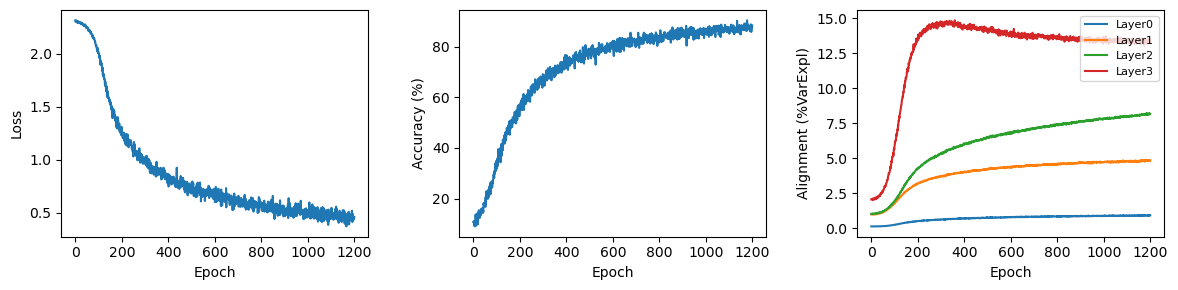

In [5]:
# This code plots absolute values of loss, accuracy, similarity, and integration
# -- useful for knowing what the true (unnormalized) values are --
numEpoch = results['trackLoss'].shape[0]
alignMean = models.CNN2P2.avgFromFull(results['alignFull'])
# Note: similarity and integration are only current -- I changed it to simMean,intMean,simStd,intStd for future reference and for plotting error bars!
fig,ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(results['trackLoss'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results['trackAccuracy'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
for i in range(alignMean.shape[0]):
    ax[2].plot(alignMean[i,:]*100,label=f'Layer{i}')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment (%VarExpl)')
ax[2].legend(fontsize=8, loc='upper right')

plt.tight_layout()

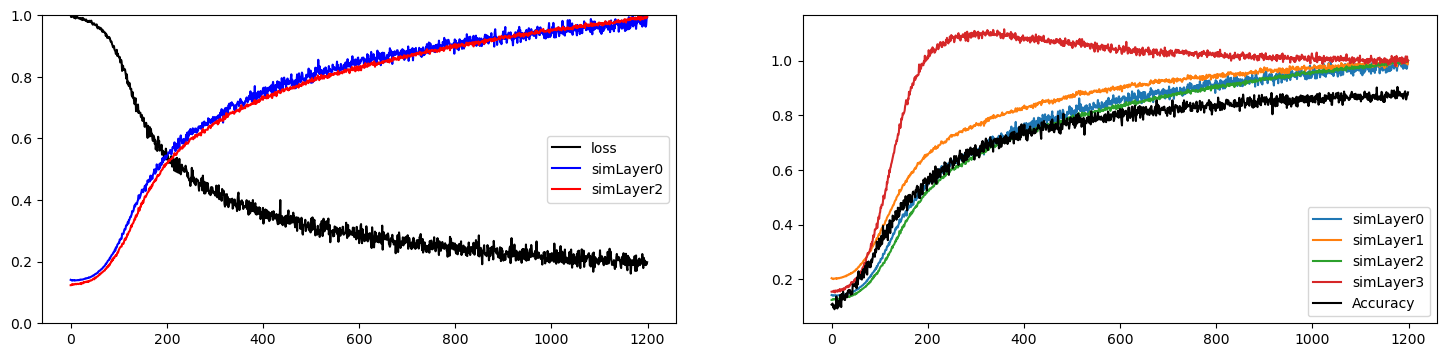

In [6]:
# This code plots relative loss & accuracy with similarity and integration to compare timescales of change
i1 = 0
i2 = 2
fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(range(numEpoch), results['trackLoss'] / torch.max(results['trackLoss']), c='k', label='loss')
ax[0].plot(range(numEpoch), alignMean[i1,:] / torch.max(alignMean[i1,:]), c='b', label=f'simLayer{i1}')
ax[0].plot(range(numEpoch), alignMean[i2,:] / torch.max(alignMean[i2,:]), c='r', label=f'simLayer{i2}')
ax[0].set_ylim(0,1)
ax[0].legend(loc='center right')
for i in range(alignMean.shape[0]):
    ax[1].plot(range(numEpoch),alignMean[i,:]/alignMean[i,-1], label=f'simLayer{i}')
ax[1].plot(range(numEpoch),results['trackAccuracy']/100, c='k', label='Accuracy')
ax[1].legend(loc='lower right')

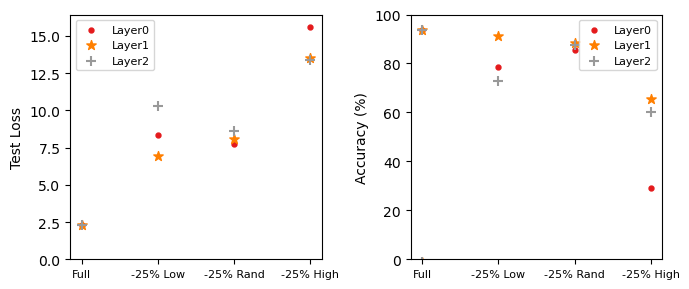

In [9]:
# Analyze test loss with targeted dropout experiment
numLayers = alignMean.shape[0]
alignLayer = []
for layer in range(numLayers):
    alignLayer.append(models.CNN2P2.layerFromFull(results['alignFull'],layer))

results['net'].setDropout(0)

dropoutFraction = 0.7
numLayers = len(alignLayer)-1
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...

loss = torch.zeros(numLayers)
lossNoHi = torch.zeros(numLayers)
lossNoLo = torch.zeros(numLayers)
lossRnd = torch.zeros(numLayers)
accuracy = torch.zeros(numLayers)
accuracyNoHi = torch.zeros(numLayers)
accuracyNoLo = torch.zeros(numLayers)
accuracyRnd = torch.zeros(numLayers)
for layer in range(numLayers):
    num2look = int(dropoutFraction * alignLayer[layer].shape[0])
    idxFinalAlignment = torch.argsort(alignLayer[layer][:,-1])
    idxHi = idxFinalAlignment[-num2look:]
    idxLo = idxFinalAlignment[:num2look]

    # For each network / layer combination
    numAttempted = 0
    for batch in results['testloader']:
        images,label = batch
        images = images.to(DEVICE)
        label = label.to(DEVICE)
        numAttempted += images.shape[0]

        # Get loss for no high
        outputs = models.MLP4.targetedDropout(results['net'], images, idxHi, layer)
        lossNoHi[layer] += loss_function(outputs,label).item()
        output1 = torch.argmax(outputs,axis=1)
        accuracyNoHi[layer] += sum(output1==label).cpu()
        # Get loss for no low
        outputs = models.MLP4.targetedDropout(results['net'], images, idxLo, layer)
        lossNoLo[layer] += loss_function(outputs,label).item()
        output1 = torch.argmax(outputs,axis=1)
        accuracyNoLo[layer] += sum(output1==label).cpu()

        # Get general loss
        outputs = results['net'](images)
        loss[layer] += loss_function(outputs,label).item()
        output1 = torch.argmax(outputs,axis=1)
        accuracy[layer] += sum(output1==label).cpu()
        # Get loss for random dropout
        idxRandom = torch.randperm(alignLayer[layer].shape[0])[:num2look]
        outputs = models.MLP4.targetedDropout(results['net'], images, idxRandom, layer)
        lossRnd[layer] += loss_function(outputs,label).item()
        output1 = torch.argmax(outputs,axis=1)
        accuracyRnd[layer] += sum(output1==label).cpu()
            
accuracy = 100*accuracy/numAttempted
accuracyNoHi = 100*accuracyNoHi/numAttempted
accuracyNoLo = 100*accuracyNoLo/numAttempted
accuracyRnd = 100*accuracyRnd/numAttempted

# Plot Results of Targeted Dropout Experiment
mkrSize = 50
rndSpread = 0.05
alpha = 1
fontsize=8
cmap = cm.get_cmap('Set1', numLayers).colors
mrkTypes=['.','*','+','x']

fig,ax = plt.subplots(1,2,figsize=(7,3))
for slayer in range(numLayers):
    ax[0].scatter(0, -1, color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
    ax[1].scatter(0, -1, color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
        
    ax[0].scatter(0, loss[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(1, lossNoLo[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(2, lossRnd[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(3, lossNoHi[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)

    ax[1].scatter(0, accuracy[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(1, accuracyNoLo[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(2, accuracyRnd[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(3, accuracyNoHi[slayer], color=cmap[slayer], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
xTickLabel=['Full','-25% Low','-25% Rand','-25% High']
ax[0].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[1].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[0].set_ylim(0,None)
ax[1].set_ylim(0,100)
ax[0].set_ylabel('Test Loss')
ax[1].set_ylabel('Accuracy (%)')
ax[0].legend(fontsize=fontsize,loc='best')
ax[1].legend(fontsize=fontsize,loc='best')

plt.tight_layout();

In [10]:
# Measure eigenvectors of images
allImages = []
for images,label in results['testloader']:
    allImages.append(images)
allImages = torch.cat(allImages)
imCov = torch.cov(allImages.T)
imEval,imEvec = torch.linalg.eigh(imCov)
imEval,idxEval = torch.sort(imEval, descending=True)
imEvec = imEvec[:,idxEval]
NEV = len(imEval)

# Measure dot product of first layer weights on eigenvectors
w1 = results['net'].fc1.weight.clone().cpu().detach()
w1 = w1 / torch.norm(w1,dim=1) # make sure they are normed!
beta = torch.abs(imEvec.T @ w1.T)

# Measure dot product of RFs on images
wActivations = allImages @ w1.T

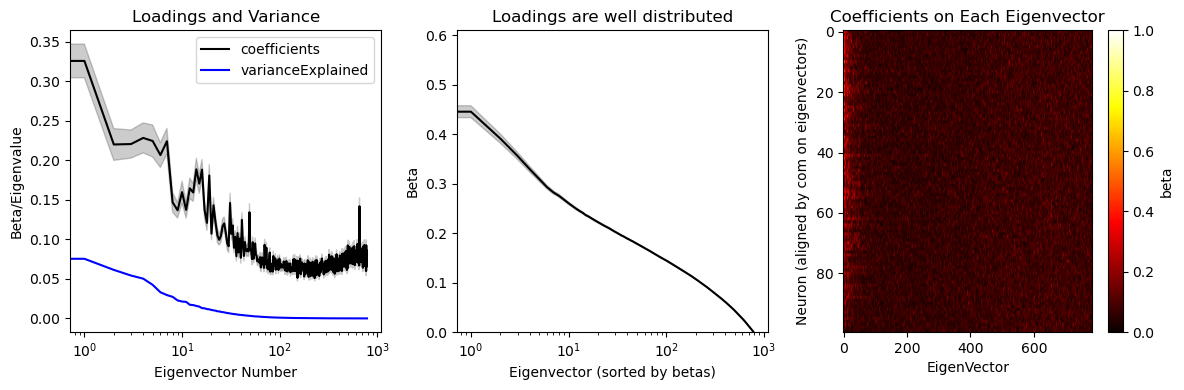

In [11]:
# Measure eigenstructure of neuron weights

# Make summary plots of betas
fig,ax = plt.subplots(1,3,figsize=(12,4))

# Plot betas
mnBeta = torch.mean(beta, dim=1)
seBeta = torch.std(beta, dim=1)/np.sqrt(beta.shape[1])
# plt.plot(range(NEV), beta, c='lightgrey', linewidth=0.2, alpha=0.1)
ax[0].plot(range(NEV), torch.mean(beta, dim=1), c='k', linewidth=1.5, label='coefficients')
ax[0].fill_between(range(NEV), mnBeta+seBeta, mnBeta-seBeta, color='k', alpha=0.2)
ax[0].plot(range(NEV), imEval / torch.sum(imEval), c='b', label='varianceExplained')
ax[0].legend()
ax[0].set_xlabel('Eigenvector Number')
ax[0].set_ylabel('Beta/Eigenvalue')
ax[0].set_title('Loadings and Variance')
ax[0].set_xscale('log')

# Plot line of sorted betas
# seCorrection = np.sqrt(np.sum(idxlr)*beta.shape[2])
sortBeta = torch.sort(beta,dim=0,descending=True)[0]
mnSortBeta = torch.mean(sortBeta,dim=1)
seSortBeta = torch.std(sortBeta,dim=1)/np.sqrt(sortBeta.shape[1])
ax[1].plot(range(NEV), mnSortBeta, c='k', linewidth=1.5, label='beta')
ax[1].fill_between(range(NEV), mnSortBeta+seSortBeta, mnSortBeta-seSortBeta, color='k', alpha=0.2)
ax[1].set_ylim(0)
ax[1].set_xlabel('Eigenvector (sorted by betas)')
ax[1].set_ylabel('Beta')
ax[1].set_title('Loadings are well distributed')
ax[1].set_xscale('log')

# Plot heatmap of all coefficients (sorted by COM)
use2sort = 'eval'
comVals = imEval if use2sort=='eval' else np.arange(NEV)
comBeta = (comVals @ beta.numpy()) / torch.sum(beta * beta, dim=0)
idxComBeta = torch.argsort(comBeta,descending=True)
hm=ax[2].imshow(beta[:,idxComBeta].T,aspect='auto', cmap='hot', vmin=0, vmax=1)
ax[2].set_xlabel('EigenVector')
ax[2].set_ylabel('Neuron (aligned by com on eigenvectors)')
ax[2].set_title('Coefficients on Each Eigenvector')
# ax[2].set_xscale('log')
plt.colorbar(hm, ax=ax[2], label='beta')

# Make it pretty
plt.tight_layout()

# Compare entropy of betas to similarity
normBeta = beta/torch.sum(beta,dim=0)
entropy = -torch.nansum(normBeta * torch.log2(beta),dim=0)
# plt.hist(entropy.numpy())

## Main Analysis Code Below
The first block performs multiple runs and saves the data. 
The second block loads the data and transforms it to useable arrays. 
The next group of blocks analyzes and plots the data. 

In [58]:
# Perform many runs
useNet = 'MLP4' # 'CNN2P2'
iterations = 50
learningRate = (5e-2, 2e-2, 8e-3)
numRuns = 10
numLR = len(learningRate)

saveDir=Path('../data/integrationMNIST')
if not os.path.exists(saveDir): os.makedirs(saveDir)

runOffset = 0
doMultipleRuns = False
if doMultipleRuns:
    # Do Runs
    for runIdx in range(numRuns):
        for lr in tqdm(range(numLR)):
            print(f"Learning Rate: {lr+1}/{numLR}, Run: {runIdx+1}/{numRuns}...")
            results = nnexp.runExperiment_measureIntegrationMNIST(useNet=useNet,iterations=iterations,learningRate=learningRate[lr],verbose=False,dataPath=None)

            # And Save
            fileName=f'integrationMNIST_{useNet}_{runIdx+runOffset}_LR{lr}.pkl'
            with open(saveDir / fileName, 'wb') as f:
                pickle.dump(results, f)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 1/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.20%.
Training process has finished in 118.750 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:00, 120.15s/it]

Learning Rate: 2/3, Run: 1/10...
Initiating experiment using cuda
Average loss over test set: 0.16.
Accuracy over test set: 95.37%.
Training process has finished in 118.884 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.21s/it]

Learning Rate: 3/3, Run: 1/10...
Initiating experiment using cuda
Average loss over test set: 0.27.
Accuracy over test set: 92.06%.
Training process has finished in 120.388 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 2/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.27%.
Training process has finished in 121.764 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:03<04:06, 123.17s/it]

Learning Rate: 2/3, Run: 2/10...
Initiating experiment using cuda
Average loss over test set: 0.15.
Accuracy over test set: 95.45%.
Training process has finished in 121.216 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:05<02:02, 122.84s/it]

Learning Rate: 3/3, Run: 2/10...
Initiating experiment using cuda
Average loss over test set: 0.25.
Accuracy over test set: 92.47%.
Training process has finished in 120.469 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 3/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 96.98%.
Training process has finished in 119.087 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:00, 120.39s/it]

Learning Rate: 2/3, Run: 3/10...
Initiating experiment using cuda
Average loss over test set: 0.16.
Accuracy over test set: 95.24%.
Training process has finished in 118.864 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.25s/it]

Learning Rate: 3/3, Run: 3/10...
Initiating experiment using cuda
Average loss over test set: 0.26.
Accuracy over test set: 92.34%.
Training process has finished in 118.997 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 4/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.15%.
Training process has finished in 118.898 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:00, 120.28s/it]

Learning Rate: 2/3, Run: 4/10...
Initiating experiment using cuda
Average loss over test set: 0.14.
Accuracy over test set: 95.79%.
Training process has finished in 118.829 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.26s/it]

Learning Rate: 3/3, Run: 4/10...
Initiating experiment using cuda
Average loss over test set: 0.26.
Accuracy over test set: 92.65%.
Training process has finished in 119.297 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 5/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.19%.
Training process has finished in 119.463 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:01, 120.87s/it]

Learning Rate: 2/3, Run: 5/10...
Initiating experiment using cuda
Average loss over test set: 0.15.
Accuracy over test set: 95.67%.
Training process has finished in 119.007 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:01<02:00, 120.60s/it]

Learning Rate: 3/3, Run: 5/10...
Initiating experiment using cuda
Average loss over test set: 0.27.
Accuracy over test set: 92.16%.
Training process has finished in 118.910 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 6/10...
Initiating experiment using cuda
Average loss over test set: 0.10.
Accuracy over test set: 97.10%.
Training process has finished in 118.642 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [01:59<03:59, 119.95s/it]

Learning Rate: 2/3, Run: 6/10...
Initiating experiment using cuda
Average loss over test set: 0.15.
Accuracy over test set: 95.44%.
Training process has finished in 118.728 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.05s/it]

Learning Rate: 3/3, Run: 6/10...
Initiating experiment using cuda
Average loss over test set: 0.26.
Accuracy over test set: 92.44%.
Training process has finished in 119.067 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 7/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.34%.
Training process has finished in 119.342 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:01, 120.74s/it]

Learning Rate: 2/3, Run: 7/10...
Initiating experiment using cuda
Average loss over test set: 0.15.
Accuracy over test set: 95.55%.
Training process has finished in 118.695 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.34s/it]

Learning Rate: 3/3, Run: 7/10...
Initiating experiment using cuda
Average loss over test set: 0.26.
Accuracy over test set: 92.53%.
Training process has finished in 118.700 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 8/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.34%.
Training process has finished in 118.778 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:00, 120.08s/it]

Learning Rate: 2/3, Run: 8/10...
Initiating experiment using cuda
Average loss over test set: 0.15.
Accuracy over test set: 95.79%.
Training process has finished in 119.201 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.34s/it]

Learning Rate: 3/3, Run: 8/10...
Initiating experiment using cuda
Average loss over test set: 0.27.
Accuracy over test set: 92.15%.
Training process has finished in 118.895 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 9/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.19%.
Training process has finished in 119.176 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:01, 120.55s/it]

Learning Rate: 2/3, Run: 9/10...
Initiating experiment using cuda
Average loss over test set: 0.15.
Accuracy over test set: 95.46%.
Training process has finished in 118.721 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.29s/it]

Learning Rate: 3/3, Run: 9/10...
Initiating experiment using cuda
Average loss over test set: 0.26.
Accuracy over test set: 92.49%.
Training process has finished in 118.589 seconds.


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Learning Rate: 1/3, Run: 10/10...
Initiating experiment using cuda
Average loss over test set: 0.09.
Accuracy over test set: 97.15%.
Training process has finished in 118.663 seconds.


 33%|███████████████████████████▋                                                       | 1/3 [02:00<04:00, 120.04s/it]

Learning Rate: 2/3, Run: 10/10...
Initiating experiment using cuda
Average loss over test set: 0.14.
Accuracy over test set: 95.59%.
Training process has finished in 118.900 seconds.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:00<02:00, 120.22s/it]

Learning Rate: 3/3, Run: 10/10...
Initiating experiment using cuda
Average loss over test set: 0.26.
Accuracy over test set: 92.37%.
Training process has finished in 118.871 seconds.


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:00<00:00, 120.23s/it]


In [72]:
# Analyze multiple runs (need to do this before running dropout+retraining experiment)
useNet = 'MLP4'
fileNames = glob(f"../data/integrationMNIST/integrationMNIST_{useNet}_*.pkl")
NF = len(fileNames)

nets = []
alignFull = []
deltaWeights = []
trackLoss = []
trackAccuracy = []
learningRate = []
runIdx = []
for file in tqdm(fileNames):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        nets.append(results['net'])
        alignFull.append(results['alignFull'])
        deltaWeights.append(results['deltaWeights'])
        trackLoss.append(results['trackLoss'])
        trackAccuracy.append(results['trackAccuracy'])
        runIdx.append(int(file[file.find(f'{useNet}')+len(useNet)+1:file.find('_LR')]))
        learningRate.append(int(file[file.find('LR')+2:-4]))

# Also keep these (it's the same for each run)
trainloader = results['trainloader']
testloader = results['testloader']
runIdx = np.array(runIdx)
learningRate = np.array(learningRate)
lrVals = np.unique(learningRate)

# Just for the reminder...
print(f"Keys available from results dictionary: {results.keys()}")

# Get better formatted summary statistics 
alignLayer0 = []
alignLayer1 = []
alignLayer2 = []
alignLayer3 = []
alignMean = []
dwLayer0 = []
dwLayer1= []
dwLayer2= []
dwLayer3= []
for sf,dw in zip(alignFull,deltaWeights):
    alignMean.append(models.CNN2P2.avgFromFull(sf))
    alignLayer0.append(models.CNN2P2.layerFromFull(sf,0))
    alignLayer1.append(models.CNN2P2.layerFromFull(sf,1))
    alignLayer2.append(models.CNN2P2.layerFromFull(sf,2))
    alignLayer3.append(models.CNN2P2.layerFromFull(sf,3))
    dwLayer0.append(models.CNN2P2.layerFromFull(dw,0))
    dwLayer1.append(models.CNN2P2.layerFromFull(dw,1))
    dwLayer2.append(models.CNN2P2.layerFromFull(dw,2))
    dwLayer3.append(models.CNN2P2.layerFromFull(dw,3))

# Do some helpful change to types and shapes
trackLoss = torch.stack(trackLoss)
trackAccuracy = torch.stack(trackAccuracy)
alignMean = torch.stack(alignMean)
alignLayer = [torch.stack(alignLayer0),torch.stack(alignLayer1),torch.stack(alignLayer2),torch.stack(alignLayer3)]
dwLayer = [torch.stack(dwLayer0),torch.stack(dwLayer1),torch.stack(dwLayer2),torch.stack(dwLayer3)]
del alignLayer0, alignLayer1, alignLayer2, alignLayer3, dwLayer0, dwLayer1, dwLayer2, dwLayer3

# And for reminder, print shapes of them
print(f"TrackLoss.shape:{trackLoss.shape}, TrackAccuracy.shape:{trackAccuracy.shape}")
print(f"AlignMean.shape:{alignMean.shape}, len(AlignLayer):{len(alignLayer)}, alignLayer[0].shape:{alignLayer[0].shape}, len(dwLayer):{len(dwLayer)}, dwLayer[0].shape:{dwLayer[0].shape}")

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:47<00:00,  1.58s/it]


Keys available from results dictionary: dict_keys(['net', 'initWeights', 'alignFull', 'deltaWeights', 'trackLoss', 'trackAccuracy', 'trainset', 'testset', 'trainloader', 'testloader', 'learningRate'])
TrackLoss.shape:torch.Size([30, 3000]), TrackAccuracy.shape:torch.Size([30, 3000])
AlignMean.shape:torch.Size([30, 4, 3000]), len(AlignLayer):4, alignLayer[0].shape:torch.Size([30, 100, 3000]), len(dwLayer):4, dwLayer[0].shape:torch.Size([30, 100, 3000])


In [92]:
# Perform dropout and retraining experiment (long code block!!!)
# -- note: must load results of run before running this block (using the code block above this one)


# -- details: dropout 50%, either from high or low alignment side (of full network e.g. layers 0, 1 & 2) -- 
dropoutFraction = 0.5
dropoutLayer = [0,1,2]
iterations = 30
retrainLearningRate = 5e-2

saveDir=Path('../data/integrationMNIST')
if not os.path.exists(saveDir): os.makedirs(saveDir)

doRetraining = False
if doRetraining:
    progressBar = tqdm(range(len(runIdx)))
    # For each trained network, save retraining after dropping high and low (dropping out 'dropoutFraction' of neurons in each layer) 
    for netidx in progressBar:
        cRunIdx = runIdx[netidx]
        cLRIdx = learningRate[netidx]
        if cLRIdx!=0: continue # not worth it to do all of them...
        progressBar.set_description(f"Retraining net {netidx+1}/{len(runIdx)} after dropping out {dropoutFraction*100:.1f}% of most aligned weights.")
        
        # Perform dropout from top half of neurons according to alignment
        dropoutIndex = []
        for dl in dropoutLayer:
            idxFinalAlignment = torch.argsort(alignLayer[dl][netidx,:,-1])
            if useNet=='CNN2P2':
                if dl==0:
                    numUnits=nets[netidx].conv1.bias.shape[0]
                if dl==1: 
                    numUnits=nets[netidx].conv2.bias.shape[0]
                if dl==2: 
                    numUnits=nets[netidx].fc1.bias.shape[0]
            elif useNet=='MLP4':
                if dl==0:
                    numUnits=nets[netidx].fc1.bias.shape[0]
                if dl==1: 
                    numUnits=nets[netidx].fc2.bias.shape[0]
                if dl==2: 
                    numUnits=nets[netidx].fc3.bias.shape[0]
            else:
                raise ValueError("Didn't recognize useNet")

            # Get number of units to remove, and pick them 
            numUnits2Remove = int(numUnits * dropoutFraction)
            idxRemove = idxFinalAlignment[-numUnits2Remove:]
            
            # Add remove index to dropout list
            dropoutIndex.append(idxRemove)
        
        # The retrain on reduced network
        retrainedDropHi = nnexp.retrainNetwork(nets[netidx], useNet, dropoutLayer, dropoutIndex, trainloader, testloader, iterations=iterations, learningRate=retrainLearningRate, verbose=False)
        
        # And Save
        fileName=f'retrainDropHi50_{useNet}_{cRunIdx}_LR{cLRIdx}.pkl'
        with open(saveDir / fileName, 'wb') as f:
            pickle.dump(retrainedDropHi, f)
        
        # --------------------------------------------------------------------------------------------------------------------------------------------------------
        progressBar.set_description(f"Retraining net {netidx+1}/{len(runIdx)} after dropping out {dropoutFraction*100:.1f}% of least aligned weights.")
        
        # Perform dropout from bottom half of neurons according to alignment
        dropoutIndex = []
        for dl in dropoutLayer:
            idxFinalAlignment = torch.argsort(alignLayer[dl][netidx,:,-1])
            if useNet=='CNN2P2':
                if dl==0:
                    numUnits=nets[netidx].conv1.bias.shape[0]
                if dl==1: 
                    numUnits=nets[netidx].conv2.bias.shape[0]
                if dl==2: 
                    numUnits=nets[netidx].fc1.bias.shape[0]
            elif useNet=='MLP4':
                if dl==0:
                    numUnits=nets[netidx].fc1.bias.shape[0]
                if dl==1: 
                    numUnits=nets[netidx].fc2.bias.shape[0]
                if dl==2: 
                    numUnits=nets[netidx].fc3.bias.shape[0]
            else:
                raise ValueError("Didn't recognize useNet")

            # Get number of units to remove, and pick them 
            numUnits2Remove = int(numUnits * dropoutFraction)
            idxRemove = idxFinalAlignment[:numUnits2Remove]
            
            # Add remove index to dropout list
            dropoutIndex.append(idxRemove)
        
        # The retrain on reduced network
        retrainedDropLo = nnexp.retrainNetwork(nets[netidx], useNet, dropoutLayer, dropoutIndex, trainloader, testloader, iterations=iterations, learningRate=retrainLearningRate, verbose=False)
        
        # And Save
        fileName=f'retrainDropLo50_{useNet}_{cRunIdx}_LR{cLRIdx}.pkl'
        with open(saveDir / fileName, 'wb') as f:
            pickle.dump(retrainedDropLo, f)

In [95]:
# Analyze multiple runs + retraining runs
useNet = 'MLP4'
fileNames = glob(f"../data/integrationMNIST/integrationMNIST_{useNet}_*.pkl")
NF = len(fileNames)

nets = []
alignFull = []
deltaWeights = []
trackLoss = []
trackAccuracy = []
learningRate = []
runIdx = []
for file in tqdm(fileNames):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        nets.append(results['net'])
        alignFull.append(results['alignFull'])
        deltaWeights.append(results['deltaWeights'])
        trackLoss.append(results['trackLoss'])
        trackAccuracy.append(results['trackAccuracy'])
        runIdx.append(int(file[file.find(f'{useNet}')+len(useNet)+1:file.find('_LR')]))
        learningRate.append(int(file[file.find('LR')+2:-4]))

# Also keep these (it's the same for each run)
trainloader = results['trainloader']
testloader = results['testloader']
runIdx = np.array(runIdx)
learningRate = np.array(learningRate)
lrVals = np.unique(learningRate)

# Just for the reminder...
print(f"Keys available from results dictionary: {results.keys()}")

# Get better formatted summary statistics 
alignLayer0 = []
alignLayer1 = []
alignLayer2 = []
alignLayer3 = []
alignMean = []
dwLayer0 = []
dwLayer1= []
dwLayer2= []
dwLayer3= []
for sf,dw in zip(alignFull,deltaWeights):
    alignMean.append(models.CNN2P2.avgFromFull(sf))
    alignLayer0.append(models.CNN2P2.layerFromFull(sf,0))
    alignLayer1.append(models.CNN2P2.layerFromFull(sf,1))
    alignLayer2.append(models.CNN2P2.layerFromFull(sf,2))
    alignLayer3.append(models.CNN2P2.layerFromFull(sf,3))
    dwLayer0.append(models.CNN2P2.layerFromFull(dw,0))
    dwLayer1.append(models.CNN2P2.layerFromFull(dw,1))
    dwLayer2.append(models.CNN2P2.layerFromFull(dw,2))
    dwLayer3.append(models.CNN2P2.layerFromFull(dw,3))

# Do some helpful change to types and shapes
trackLoss = torch.stack(trackLoss)
trackAccuracy = torch.stack(trackAccuracy)
alignMean = torch.stack(alignMean)
alignLayer = [torch.stack(alignLayer0),torch.stack(alignLayer1),torch.stack(alignLayer2),torch.stack(alignLayer3)]
dwLayer = [torch.stack(dwLayer0),torch.stack(dwLayer1),torch.stack(dwLayer2),torch.stack(dwLayer3)]
del alignLayer0, alignLayer1, alignLayer2, alignLayer3, dwLayer0, dwLayer1, dwLayer2, dwLayer3

# And for reminder, print shapes of them
print(f"TrackLoss.shape:{trackLoss.shape}, TrackAccuracy.shape:{trackAccuracy.shape}")
print(f"AlignMean.shape:{alignMean.shape}, len(AlignLayer):{len(alignLayer)}, alignLayer[0].shape:{alignLayer[0].shape}, len(dwLayer):{len(dwLayer)}, dwLayer[0].shape:{dwLayer[0].shape}")


loadRetrainingData = True
if loadRetrainingData:
    # Get data from retraining runs (start with dropping high alignment neurons)
    fileNames = glob(f"../data/integrationMNIST/retrainDropHi50_{useNet}_*.pkl")
    NF = len(fileNames)

    retrainDoHi = []
    alignFullDoHi = []
    deltaWeightsDoHi = []
    trackLossDoHi = []
    trackAccuracyDoHi = []
    learningRateDoHi = []
    runIdxDoHi = []
    for file in tqdm(fileNames):
        with open(file, 'rb') as f:
            results = pickle.load(f)
            retrainDoHi.append(results['net'])
            alignFullDoHi.append(results['alignFull'])
            deltaWeightsDoHi.append(results['deltaWeights'])
            trackLossDoHi.append(results['trackLoss'])
            trackAccuracyDoHi.append(results['trackAccuracy'])
            runIdxDoHi.append(int(file[file.find(f'{useNet}')+len(useNet)+1:file.find('_LR')]))
            learningRateDoHi.append(int(file[file.find('LR')+2:-4]))

    # Also keep these (it's the same for each run)
    runIdxDoHi = np.array(runIdx)
    learningRateDoHi = np.array(learningRate)
    lrValsDoHi = np.unique(learningRate)

    
    # Get data from retraining runs (continue with dropping low alignment neurons)
    fileNames = glob(f"../data/integrationMNIST/retrainDropLo50_{useNet}_*.pkl")
    NF = len(fileNames)

    retrainDoLo = []
    alignFullDoLo = []
    deltaWeightsDoLo = []
    trackLossDoLo = []
    trackAccuracyDoLo = []
    learningRateDoLo = []
    runIdxDoLo = []
    for file in tqdm(fileNames):
        with open(file, 'rb') as f:
            results = pickle.load(f)
            retrainDoLo.append(results['net'])
            alignFullDoLo.append(results['alignFull'])
            deltaWeightsDoLo.append(results['deltaWeights'])
            trackLossDoLo.append(results['trackLoss'])
            trackAccuracyDoLo.append(results['trackAccuracy'])
            runIdxDoLo.append(int(file[file.find(f'{useNet}')+len(useNet)+1:file.find('_LR')]))
            learningRateDoLo.append(int(file[file.find('LR')+2:-4]))

    # Also keep these (it's the same for each run)
    runIdxDoLo = np.array(runIdx)
    learningRateDoLo = np.array(learningRate)
    lrValsDoLo = np.unique(learningRate)

trackLossDoLo = torch.stack(trackLossDoLo)
trackLossDoHi = torch.stack(trackLossDoHi)
trackAccuracyDoLo = torch.stack(trackAccuracyDoLo)
trackAccuracyDoHi = torch.stack(trackAccuracyDoHi)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:47<00:00,  1.58s/it]


Keys available from results dictionary: dict_keys(['net', 'initWeights', 'alignFull', 'deltaWeights', 'trackLoss', 'trackAccuracy', 'trainset', 'testset', 'trainloader', 'testloader', 'learningRate'])
TrackLoss.shape:torch.Size([30, 3000]), TrackAccuracy.shape:torch.Size([30, 3000])
AlignMean.shape:torch.Size([30, 4, 3000]), len(AlignLayer):4, alignLayer[0].shape:torch.Size([30, 100, 3000]), len(dwLayer):4, dwLayer[0].shape:torch.Size([30, 100, 3000])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s]


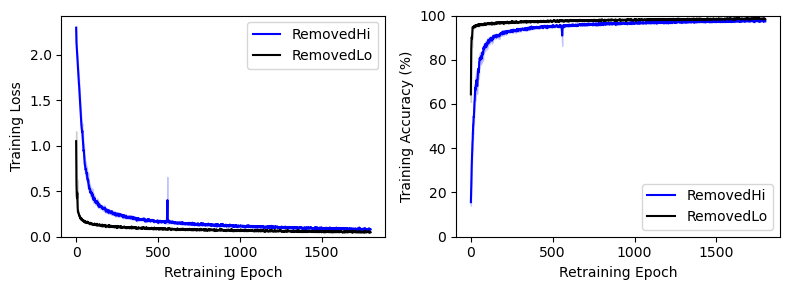

In [96]:
NT = trackLossDoLo.shape[1]

fig,ax = plt.subplots(1,2,figsize=(8,3))
mnLossDoHi = torch.mean(trackLossDoHi,dim=0)
seLossDoHi = torch.std(trackLossDoHi,dim=0)/np.sqrt(trackLossDoHi.shape[0])
mnLossDoLo = torch.mean(trackLossDoLo,dim=0)
seLossDoLo = torch.std(trackLossDoLo,dim=0)/np.sqrt(trackLossDoLo.shape[0])
ax[0].plot(range(NT), mnLossDoHi, c='b', label='RemovedHi')
ax[0].fill_between(range(NT), mnLossDoHi+seLossDoHi, mnLossDoHi-seLossDoHi, color='b', alpha=0.2)
ax[0].plot(range(NT), mnLossDoLo, c='k', label='RemovedLo')
ax[0].fill_between(range(NT), mnLossDoLo+seLossDoLo, mnLossDoLo-seLossDoLo, color='k', alpha=0.2)
ax[0].set_xlabel('Retraining Epoch')
ax[0].set_ylabel('Training Loss')
ax[0].set_ylim(0)
ax[0].legend()

mnAccuracyDoHi = torch.mean(trackAccuracyDoHi,dim=0)
seAccuracyDoHi = torch.std(trackAccuracyDoHi,dim=0)/np.sqrt(trackAccuracyDoHi.shape[0])
mnAccuracyDoLo = torch.mean(trackAccuracyDoLo,dim=0)
seAccuracyDoLo = torch.std(trackAccuracyDoLo,dim=0)/np.sqrt(trackAccuracyDoLo.shape[0])
ax[1].plot(range(NT), mnAccuracyDoHi, c='b', label='RemovedHi')
ax[1].fill_between(range(NT), mnAccuracyDoHi+seAccuracyDoHi, mnAccuracyDoHi-seAccuracyDoHi, color='b', alpha=0.2)
ax[1].plot(range(NT), mnAccuracyDoLo, c='k', label='RemovedLo')
ax[1].fill_between(range(NT), mnAccuracyDoLo+seAccuracyDoLo, mnAccuracyDoLo-seAccuracyDoLo, color='k', alpha=0.2)
ax[1].set_xlabel('Retraining Epoch')
ax[1].set_ylabel('Training Accuracy (%)')
ax[1].set_ylim(0,100)
ax[1].legend()

plt.tight_layout()

In [ ]:

# need to write some code to stack retraining data in useful way


In [74]:
# Analyze test loss with targeted dropout experiment
dropoutFraction = 0.25
numLayers = len(alignLayer)-1
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...

useNet = 'MLP4'
if useNet=='CNN2P2':
    targetedDropout = models.CNN2P2.targetedDropout
elif useNet=='MLP4':
    targetedDropout = models.MLP4.targetedDropout
else:
    raise ValueError("useNet not recognized")

numRuns = len(alignMean)
loss = torch.zeros((numRuns,numLayers))
lossNoHi = torch.zeros((numRuns,numLayers))
lossNoLo = torch.zeros((numRuns,numLayers))
lossRnd = torch.zeros((numRuns,numLayers))
accuracy = torch.zeros((numRuns,numLayers))
accuracyNoHi = torch.zeros((numRuns,numLayers))
accuracyNoLo = torch.zeros((numRuns,numLayers))
accuracyRnd = torch.zeros((numRuns,numLayers))
for runidx in tqdm(range(numRuns)):
    for layer in range(numLayers):
        num2look = int(dropoutFraction * alignLayer[layer].shape[1])
        idxFinalAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
        idxHi = idxFinalAlignment[-num2look:]
        idxLo = idxFinalAlignment[:num2look]
        
        # For each network / layer combination
        numAttempted = 0
        for batch in testloader:
            images,label = batch
            images = images.to(DEVICE)
            label = label.to(DEVICE)
            numAttempted += images.shape[0]
            
            # Get loss for no high
            outputs = targetedDropout(nets[runidx], images, idxHi, layer)
            lossNoHi[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyNoHi[runidx,layer] += sum(output1==label).cpu()
            # Get loss for no low
            outputs = targetedDropout(nets[runidx], images, idxLo, layer)
            lossNoLo[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyNoLo[runidx,layer] += sum(output1==label).cpu()
            
            # Get general loss
            outputs = nets[runidx](images)
            loss[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracy[runidx,layer] += sum(output1==label).cpu()
            # Get loss for random dropout
            idxRandom = torch.randperm(alignLayer[layer].shape[0])[:num2look]
            outputs = targetedDropout(nets[runidx], images, idxRandom, layer)
            lossRnd[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyRnd[runidx,layer] += sum(output1==label).cpu()
            
accuracy = 100*accuracy/numAttempted
accuracyNoHi = 100*accuracyNoHi/numAttempted
accuracyNoLo = 100*accuracyNoLo/numAttempted
accuracyRnd = 100*accuracyRnd/numAttempted

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:47<00:00,  3.59s/it]


In [80]:
# Add dropout experiment where we do a progressive dropout from lowest to highest alignment and vice-versa
# At each layer independently, and also at all layers together!
numRuns = len(alignMean)
numLayers = len(alignLayer)-1
numDrops = 9 # divide fraction evenly 
dropFraction = np.linspace(0,1,numDrops+2)[1:-1]
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...

useNet = 'MLP4'
if useNet=='CNN2P2':
    targetedDropout = models.CNN2P2.targetedDropout
elif useNet=='MLP4':
    targetedDropout = models.MLP4.targetedDropout
else:
    raise ValueError("useNet not recognized")
    
progDropLossLo = torch.zeros((numRuns,numLayers,numDrops))
progDropLossHi = torch.zeros((numRuns,numLayers,numDrops))
progDropAccuracyLo = torch.zeros((numRuns,numLayers,numDrops))
progDropAccuracyHi = torch.zeros((numRuns,numLayers,numDrops))

progressBar = tqdm(testloader)
for batch in progressBar:
    images,label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    
    for runidx in range(numRuns):
        for layer in range(numLayers):
            progressBar.set_description(f"RunIdx:{runidx+1}/{numRuns}, Layer:{layer+1}/{numLayers}")
                
            idxFinalAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
            for dropFrac in range(numDrops):
                num2look = int(dropFraction[dropFrac] * alignLayer[layer].shape[1])
                idxHi = idxFinalAlignment[-num2look:]
                idxLo = idxFinalAlignment[:num2look]
                
                # Get loss for progressive dropout of hi
                outputs = targetedDropout(nets[runidx], images, idxHi, layer)
                progDropLossHi[runidx,layer,dropFrac] += loss_function(outputs,label).item()
                output1 = torch.argmax(outputs,axis=1)
                progDropAccuracyHi[runidx,layer,dropFrac] += sum(output1==label).cpu()
                
                # Get loss for progressive dropout of low
                outputs = targetedDropout(nets[runidx], images, idxLo, layer)
                progDropLossLo[runidx,layer,dropFrac] += loss_function(outputs,label).item()
                output1 = torch.argmax(outputs,axis=1)
                progDropAccuracyLo[runidx,layer,dropFrac] += sum(output1==label).cpu()
                
# Normalize correctly
progDropLossLo = progDropLossLo/len(testloader)
progDropLossHi = progDropLossHi/len(testloader)
progDropAccuracyLo = 100*progDropAccuracyLo/len(testloader.dataset)
progDropAccuracyHi = 100*progDropAccuracyHi/len(testloader.dataset)

RunIdx:30/30, Layer:3/3: 100%|█████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.99s/it]


In [82]:
# Compare activations, incoming weight norms and outgoing weight norms with alignment of each node
numRuns = len(alignMean)
numLayers = len(alignLayer)-1
numBatches = len(trainloader)
if useNet=='CNN2P2':
    dimVariance = [(0,2,3),(0,2,3),(0)]
elif useNet=='MLP4':
    dimVariance = [(0),(0),(0)]
else:
    raise ValueError("Did not recognize useNet")

actVariance = []
weightNorms = []
outgoingNorms = []
for layer in range(numLayers):
    numNodes = alignLayer[layer].shape[1]
    actVariance.append(torch.zeros((numRuns,numNodes)))
    weightNorms.append(torch.zeros((numRuns,numNodes)))
    outgoingNorms.append(torch.zeros((numRuns,numNodes)))

# Measure activation variance
for batch in tqdm(trainloader):
    images,label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)

    for runidx in range(numRuns):
        # Get activations for this batch
        cacts = nets[runidx].getActivations(images)
        for layer in range(numLayers):
            actVariance[layer][runidx,:] += torch.var(cacts[layer],dim=dimVariance[layer]).clone().detach().cpu()

for layer in range(numLayers):
    actVariance[layer] = actVariance[layer] / len(trainloader)
            
# Measure weight norms
print("cHECK method on how to compute outgoing norm of convolutional to fully connected layer")
if useNet=='CNN2P2':
    for runidx in range(numRuns):
        weightNorms[0][runidx,:] = torch.norm(nets[runidx].conv1.weight.detach(),p=2,dim=(1,2,3))
        weightNorms[1][runidx,:] = torch.norm(nets[runidx].conv2.weight.detach(),p=2,dim=(1,2,3))
        weightNorms[2][runidx,:] = torch.norm(nets[runidx].fc1.weight.detach(),p=2,dim=1)
        outgoingNorms[0][runidx,:] = torch.norm(nets[runidx].conv2.weight.detach(),p=2,dim=(0,2,3))
        outgoingNorms[1][runidx,:] = torch.norm(nets[runidx].fc1.weight.detach().reshape(nets[runidx].fc1.weight.shape[0],4,-1),dim=(0,1))
        outgoingNorms[2][runidx,:] = torch.norm(nets[runidx].o.weight.detach(),p=2,dim=0)
elif useNet=='MLP4':
    for runidx in range(numRuns):
        weightNorms[0][runidx,:] = torch.norm(nets[runidx].fc1.weight.detach(),p=2,dim=1)
        weightNorms[1][runidx,:] = torch.norm(nets[runidx].fc2.weight.detach(),p=2,dim=1)
        weightNorms[2][runidx,:] = torch.norm(nets[runidx].fc3.weight.detach(),p=2,dim=1)
        outgoingNorms[0][runidx,:] = torch.norm(nets[runidx].fc2.weight.detach(),p=2,dim=0)
        outgoingNorms[1][runidx,:] = torch.norm(nets[runidx].fc3.weight.detach(),p=2,dim=0)
        outgoingNorms[2][runidx,:] = torch.norm(nets[runidx].fc4.weight.detach(),p=2,dim=0)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.86it/s]

cHECK method on how to compute outgoing norm of convolutional to fully connected layer


In [ ]:
# Measure alignment between the input and the delta-weight of each node










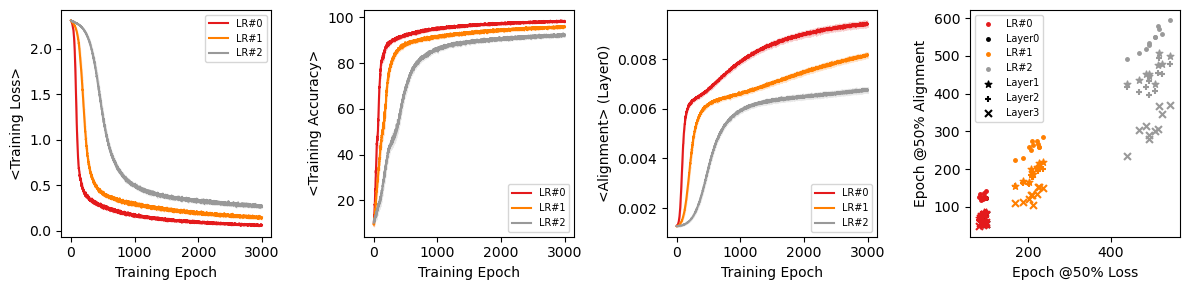

In [83]:
# Plot Analysis of Loss Trajectory and Similarity Trajectory 

# Create smoothing function
kernelSize = 10 # for smoothing trajectories
missingPoints = (kernelSize-1)
kernel = np.ones(kernelSize)/kernelSize
smooth = lambda x: np.convolve(x, kernel, mode='valid')

# Shapes and Size
NR,NT = trackLoss.shape
NL = len(alignLayer)
lrVals = np.unique(learningRate)
NLR = len(lrVals)

# Define colormap
cmap = cm.get_cmap('Set1', NLR).colors

# Make summary figure
showLayer = 0
fig,ax = plt.subplots(1,4,figsize=(12,3))

fontsize=7

# Plot loss trajectory
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnLoss = torch.mean(trackLoss[lridx],dim=0)
    seLoss = torch.std(trackLoss[lridx],dim=0)/np.sqrt(np.sum(lridx))
    ax[0].plot(range(NT), mnLoss, c=cmap[lr], label=f'LR#{lr}')
    ax[0].fill_between(range(NT), mnLoss+seLoss, mnLoss-seLoss, color=cmap[lr], alpha=0.2)
ax[0].set_xlabel('Training Epoch')
ax[0].set_ylabel('<Training Loss>')
ax[0].legend(fontsize=fontsize)

# Plot accuracy trajectory
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnAcc = torch.mean(trackAccuracy[lridx],dim=0)
    seAcc = torch.std(trackAccuracy[lridx],dim=0)/np.sqrt(np.sum(lridx))
    ax[1].plot(range(NT), mnAcc, c=cmap[lr], label=f'LR#{lr}')
    ax[1].fill_between(range(NT), mnAcc+seAcc, mnAcc-seAcc, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
ax[1].set_xlabel('Training Epoch')
ax[1].set_ylabel('<Training Accuracy>')
ax[1].legend(fontsize=fontsize)

# Plot alignment trajectory for one layer
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnAlign = torch.mean(alignMean[lridx,showLayer],dim=0)
    seAlign = torch.std(alignMean[lridx,showLayer],dim=0)/np.sqrt(np.sum(lridx))
    ax[2].plot(range(NT), mnAlign, c=cmap[lr], label=f'LR#{lr}')
    ax[2].fill_between(range(NT), mnAlign+seAlign, mnAlign-seAlign, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
ax[2].set_xlabel('Training Epoch')
ax[2].set_ylabel(f'<Alignment> (Layer{showLayer})')
ax[2].legend(fontsize=fontsize, loc='lower right')

# Compare 50% point for loss and alignment for one layer
mrkTypes=['.','*','+','x']
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        loss50 = torch.zeros(np.sum(lridx))
        align50 = torch.zeros(np.sum(lridx))
        for idx,lossAlign in enumerate(zip(trackLoss[lridx],alignMean[lridx,slayer])):
            closs,calign = lossAlign
            loss50[idx] = torch.where(closs<=np.mean([closs.min(),closs.max()]))[0][0]
            align50[idx] = torch.where(calign>=np.mean([calign.min(),calign.max()]))[0][0]
        if slayer==0:
            ax[3].scatter(loss50[0],align50[0],color=cmap[lr],s=25,marker=mrkTypes[slayer],label=f'LR#{lr}')
        if lr==0:
            ax[3].scatter(loss50[0],align50[0],color='k',s=25,marker=mrkTypes[slayer],label=f'Layer{slayer}')
        ax[3].scatter(loss50,align50,color=cmap[lr],s=25,marker=mrkTypes[slayer])
ax[3].set_xlabel('Epoch @50% Loss')
ax[3].set_ylabel(f'Epoch @50% Alignment')
ax[3].legend(fontsize=fontsize)

plt.tight_layout()

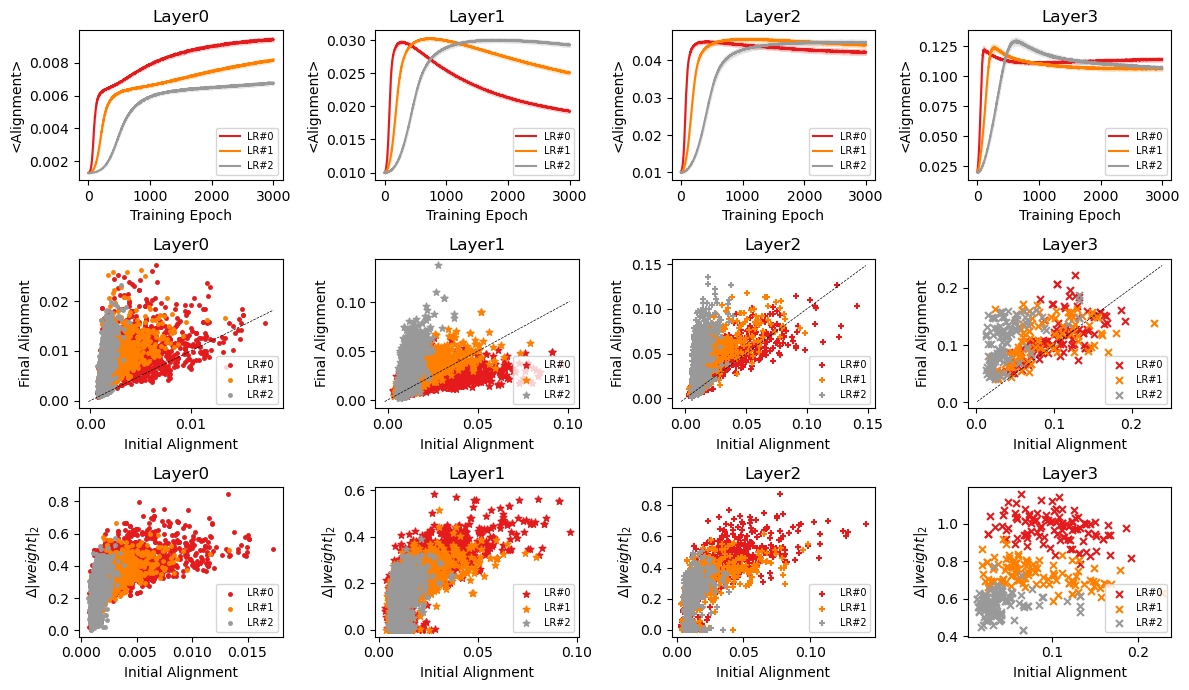

In [84]:
# Plot detailed analysis of node properties

# Make summary figure
showLayer = 0
fig,ax = plt.subplots(3,4,figsize=(12,7))

fontsize=7
alpha=1

avgFraction = 0.1
avgPoints = int(trackLoss.shape[1]*avgFraction)

# Compare initial and final alignment for each node
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        mnAlign = torch.mean(alignMean[lridx,slayer],dim=0)
        seAlign = torch.std(alignMean[lridx,slayer],dim=0)/np.sqrt(np.sum(lridx))
        ax[0,slayer].plot(range(NT), mnAlign, c=cmap[lr], label=f'LR#{lr}')
        ax[0,slayer].fill_between(range(NT), mnAlign+seAlign, mnAlign-seAlign, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
    ax[0,slayer].set_xlabel('Training Epoch')
    ax[0,slayer].set_ylabel(f'<Alignment>')
    ax[0,slayer].set_title(f'Layer{slayer}')
    ax[0,slayer].legend(fontsize=fontsize, loc='best')
    
# Compare initial and final alignment for each node
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        cinit = torch.mean(alignLayer[slayer][lridx,:,:avgPoints],dim=2)
        cfinal = torch.mean(alignLayer[slayer][lridx,:,-avgPoints:],dim=2)
        ax[1,slayer].scatter(cinit[0], cfinal[0], color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha, label=f'LR#{lr}')
        ax[1,slayer].scatter(cinit, cfinal, color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha)
    xLim=ax[1,slayer].get_xlim()
    ax[1,slayer].plot(xLim,xLim,c='k',linewidth=0.5,linestyle='--')
    ax[1,slayer].set_xlabel('Initial Alignment')
    ax[1,slayer].set_ylabel('Final Alignment')
    ax[1,slayer].set_title(f'Layer{slayer}')
    ax[1,slayer].legend(fontsize=fontsize,loc='lower right')

# Compare initial alignment and norm change in weight for each node
avgUntil = 0.1
avgPoints = int(NT*avgUntil)
dwAvg = 0.1
dwPoints = int(NT*dwAvg)
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        cAlign = torch.mean(alignLayer[slayer][lridx,:,:avgPoints],dim=2)
        cChange = torch.mean(dwLayer[slayer][lridx,:,-dwPoints:],dim=2)
        ax[2,slayer].scatter(cAlign[0], cChange[0], color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha, label=f'LR#{lr}')
        ax[2,slayer].scatter(cAlign, cChange, color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha)
    ax[2,slayer].set_xlabel('Initial Alignment')
    ax[2,slayer].set_ylabel('$\u0394|weight|_2$')
    ax[2,slayer].set_title(f'Layer{slayer}')
    ax[2,slayer].legend(fontsize=fontsize,loc='best')

plt.tight_layout()

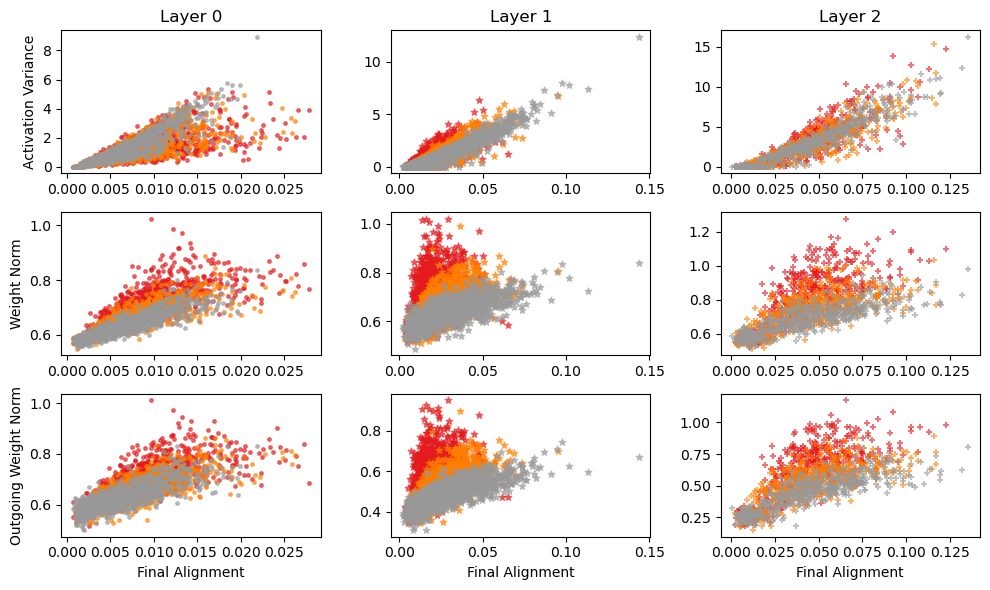

In [85]:
# Plot analysis of weight norm and activation variance for each node
mkrSize = 25
alpha=0.6

fig,ax = plt.subplots(3,numLayers,figsize=(10,6))
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    for slayer in range(numLayers):
        ax[0,slayer].scatter(alignLayer[slayer][lridx,:,-1], actVariance[slayer][lridx,:], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1,slayer].scatter(alignLayer[slayer][lridx,:,-1], weightNorms[slayer][lridx,:], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[2,slayer].scatter(alignLayer[slayer][lridx,:,-1], outgoingNorms[slayer][lridx,:], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0,slayer].set_title(f'Layer {slayer}')
        
for slayer in range(numLayers): ax[2,slayer].set_xlabel('Final Alignment')
ax[0,0].set_ylabel('Activation Variance')
ax[1,0].set_ylabel('Weight Norm')
ax[2,0].set_ylabel('Outgoing Weight Norm')

plt.tight_layout()

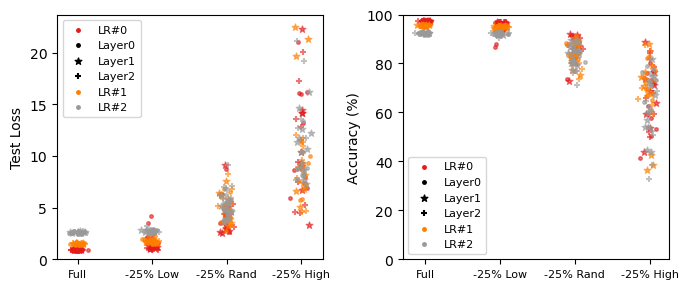

In [86]:
# Plot Results of Targeted Dropout Experiment
mkrSize = 25
rndSpread = 0.05
alpha = 0.6
fontsize=8

fig,ax = plt.subplots(1,2,figsize=(7,3))
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]    
    for slayer in range(NL-1):
        if slayer==0:
            ax[0].scatter(0, -1*loss[np.where(lridx)[0][0],slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'LR#{lr}')
            ax[1].scatter(0, -1*accuracy[np.where(lridx)[0][0],slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'LR#{lr}')
        if lr==0:
            ax[0].scatter(0, -1*loss[np.where(lridx)[0][0],slayer], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
            ax[1].scatter(0, -1*accuracy[np.where(lridx)[0][0],slayer], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
        ax[0].scatter(torch.normal(0,rndSpread,(np.sum(lridx),1)), loss[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(1,rndSpread,(np.sum(lridx),1)), lossNoLo[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(2,rndSpread,(np.sum(lridx),1)), lossRnd[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(3,rndSpread,(np.sum(lridx),1)), lossNoHi[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)

        ax[1].scatter(torch.normal(0,rndSpread,(np.sum(lridx),1)), accuracy[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(1,rndSpread,(np.sum(lridx),1)), accuracyNoLo[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(2,rndSpread,(np.sum(lridx),1)), accuracyRnd[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(3,rndSpread,(np.sum(lridx),1)), accuracyNoHi[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
xTickLabel=['Full','-25% Low','-25% Rand','-25% High']
ax[0].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[1].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[0].set_ylim(0,None)
ax[1].set_ylim(0,100)
ax[0].set_ylabel('Test Loss')
ax[1].set_ylabel('Accuracy (%)')
ax[0].legend(fontsize=fontsize,loc='best')
ax[1].legend(fontsize=fontsize,loc='best')

plt.tight_layout();

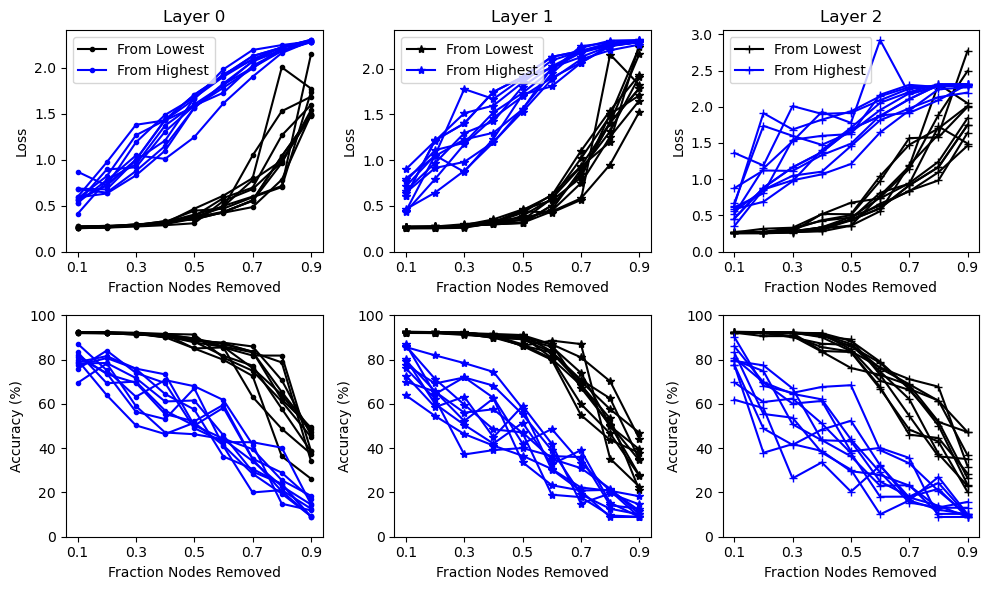

In [87]:
# Plot results of progressive loss experiment

fig,ax = plt.subplots(2,NL-1,figsize=(10,6))
useLR = 0
for slayer in range(NL-1):
    # For legend
    ax[0,slayer].plot(range(numDrops), progDropLossLo[np.where(lridx)[0][0],slayer,:], c='k', marker=mrkTypes[slayer], label='From Lowest')
    ax[0,slayer].plot(range(numDrops), progDropLossHi[np.where(lridx)[0][0],slayer,:], c='b', marker=mrkTypes[slayer], label='From Highest')
    
    ax[0,slayer].plot(range(numDrops), progDropLossLo[lridx,slayer,:].T, c='k', marker=mrkTypes[slayer])
    ax[0,slayer].plot(range(numDrops), progDropLossHi[lridx,slayer,:].T, c='b', marker=mrkTypes[slayer])
    
    ax[1,slayer].plot(range(numDrops), progDropAccuracyLo[lridx,slayer,:].T, c='k', marker=mrkTypes[slayer])
    ax[1,slayer].plot(range(numDrops), progDropAccuracyHi[lridx,slayer,:].T, c='b', marker=mrkTypes[slayer])
    
    ax[0,slayer].set_title(f'Layer {slayer}')
    ax[0,slayer].set_ylabel('Loss')
    ax[1,slayer].set_ylabel('Accuracy (%)')
    ax[0,slayer].set_xticks(range(0,numDrops,2),labels=np.round(dropFraction[::2]*10)/10)
    ax[1,slayer].set_xticks(range(0,numDrops,2),labels=np.round(dropFraction[::2]*10)/10)
    ax[0,slayer].set_xlabel('Fraction Nodes Removed')
    ax[1,slayer].set_xlabel('Fraction Nodes Removed')
    ax[0,slayer].legend()
    ax[0,slayer].set_ylim(0)
    ax[1,slayer].set_ylim(0,100)
    
plt.tight_layout()

In [104]:
# Measure eigenvectors of images
allImages = []
for images,label in testloader:
    allImages.append(images)
allImages = torch.cat(allImages)
imCov = torch.cov(allImages.T)
imEval,imEvec = torch.linalg.eigh(imCov)
imEval,idxEval = torch.sort(imEval, descending=True)
imEvec = imEvec[:,idxEval]
NEV = len(imEval)

# Measure dot product of first layer weights on eigenvectors
w1 = nets[0].fc1.weight.clone().cpu().detach()
w1 = w1 / torch.norm(w1,dim=0) # make sure they are normed!
beta = torch.abs(imEvec.T @ w1.T)

# Measure dot product of RFs on images
wActivations = allImages @ w1.T

In [109]:
beta.shape

torch.Size([784, 100])

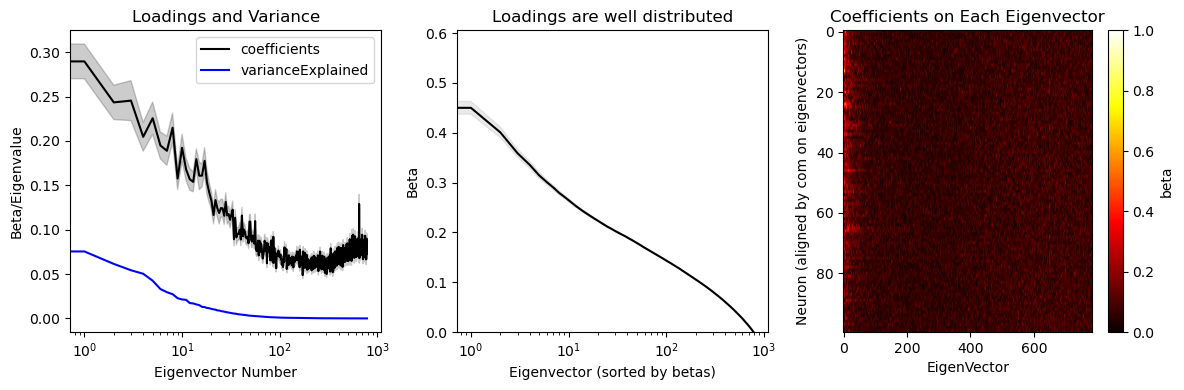

In [113]:
# Measure eigenstructure of neuron weights

# Make summary plots of betas
fig,ax = plt.subplots(1,3,figsize=(12,4))

# Plot betas
mnBeta = torch.mean(beta, dim=1)
seBeta = torch.std(beta, dim=1)/np.sqrt(beta.shape[1])
# plt.plot(range(NEV), beta, c='lightgrey', linewidth=0.2, alpha=0.1)
ax[0].plot(range(NEV), torch.mean(beta, dim=1), c='k', linewidth=1.5, label='coefficients')
ax[0].fill_between(range(NEV), mnBeta+seBeta, mnBeta-seBeta, color='k', alpha=0.2)
ax[0].plot(range(NEV), imEval / torch.sum(imEval), c='b', label='varianceExplained')
ax[0].legend()
ax[0].set_xlabel('Eigenvector Number')
ax[0].set_ylabel('Beta/Eigenvalue')
ax[0].set_title('Loadings and Variance')
ax[0].set_xscale('log')

# Plot line of sorted betas
# seCorrection = np.sqrt(np.sum(idxlr)*beta.shape[2])
sortBeta = torch.sort(beta,dim=0,descending=True)[0]
mnSortBeta = torch.mean(sortBeta,dim=1)
seSortBeta = torch.std(sortBeta,dim=1)/np.sqrt(sortBeta.shape[1])
ax[1].plot(range(NEV), mnSortBeta, c='k', linewidth=1.5, label=f'beta lr#{lr}')
ax[1].fill_between(range(NEV), mnSortBeta+seSortBeta, mnSortBeta-seSortBeta, color=cmap[lr], alpha=0.2)
ax[1].set_ylim(0)
ax[1].set_xlabel('Eigenvector (sorted by betas)')
ax[1].set_ylabel('Beta')
ax[1].set_title('Loadings are well distributed')
ax[1].set_xscale('log')

# Plot heatmap of all coefficients (sorted by COM)
use2sort = 'eval'
comVals = imEval if use2sort=='eval' else np.arange(NEV)
comBeta = (comVals @ beta.numpy()) / torch.sum(beta * beta, dim=0)
idxComBeta = torch.argsort(comBeta,descending=True)
hm=ax[2].imshow(beta[:,idxComBeta].T,aspect='auto', cmap='hot', vmin=0, vmax=1)
ax[2].set_xlabel('EigenVector')
ax[2].set_ylabel('Neuron (aligned by com on eigenvectors)')
ax[2].set_title('Coefficients on Each Eigenvector')
plt.colorbar(hm, ax=ax[2], label='beta')

# Make it pretty
plt.tight_layout()

# Compare entropy of betas to similarity
normBeta = beta/torch.sum(beta,dim=0)
entropy = -torch.nansum(normBeta * torch.log2(beta),dim=0)
# plt.hist(entropy.numpy())

In [ ]:
# Code for implementing initial weight alignment

# -- will need to add methods to each section for initializing all weights --

# We need to measure eigenspectrum of images (use trainset)
allImages = []
for images,label in trainloader:
    allImages.append(images)
allImages = torch.cat(allImages)
imCov = torch.cov(allImages.T)
imEval,imEvec = torch.linalg.eigh(imCov)
imEval,idxEval = torch.sort(imEval, descending=True)
imEvec = imEvec[:,idxEval]
imEval[imEval<0]=torch.tensor(np.finfo('float32').eps) # prevent impossible negative eigenvalues (only possible with numerical errors)
if useNet=='MLP4':
    iWeights = models.initWeights(imEvec, imEval, net.fc1.weight.data.shape[0])
    iWeights = iWeights / torch.norm(iWeights,dim=0)
    net.fc1.weight.data = iWeights.T.to(DEVICE)

In [61]:
# Check Oja's Rule implementation
B=100
D=48
H=10
xx = torch.normal(0,1,(B,D))
ww = torch.normal(0,1,(H,D))
aa = xx @ ww.T
print(xx.shape)
print(ww.shape)
print(aa.shape)

alpha = 1
# dw = alpha(xy - y2 * w)
# dw = alpha(
xyForLoop = torch.zeros(ww.shape)
ywForLoop = torch.zeros(ww.shape)
for h in range(H):
    for d in range(D):
        xyForLoop[h,d] = torch.sum(xx[:,d]*aa[:,h])
        ywForLoop[h,d] = torch.sum(aa[:,h]**2 * ww[h,d])
xyMatrix = aa.T @ xx
ywMatrix = torch.sum(ww.reshape(H,D,1) * (aa**2).T.reshape(H,B,1).permute(0,2,1),dim=2)

print(torch.allclose(xyForLoop, xyMatrix))
print(torch.allclose(ywForLoop, ywMatrix))

torch.Size([100, 48])
torch.Size([10, 48])
torch.Size([100, 10])
False
True


torch.Size([10, 48])
torch.Size([10, 48])


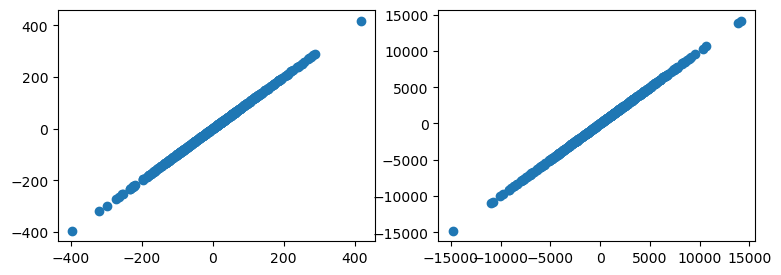

In [62]:
print(ywMatrix.shape)
print(ywForLoop.shape)
fig,ax = plt.subplots(1,2,figsize=(9,3))
ax[0].scatter(xyForLoop.reshape(-1).numpy(), xyMatrix.reshape(-1).numpy())
ax[1].scatter(ywForLoop.reshape(-1).numpy(), ywMatrix.reshape(-1).numpy())

In [43]:
print(ww.reshape(H,D,1).shape)
print(aa.T.reshape(H,B,1).permute(0,2,1).shape)

torch.Size([10, 48, 1])

In [26]:
ywMatrix.shape

torch.Size([48, 10, 100])

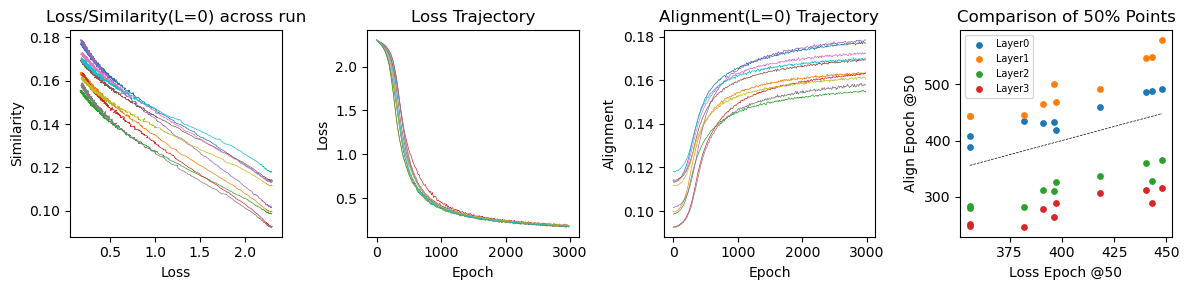

In [ ]:
# Plot Analysis of Loss Trajectory and Similarity Trajectory 

# Create smoothing function
kernelSize = 10 # for smoothing trajectories
missingPoints = (kernelSize-1)
kernel = np.ones(kernelSize)/kernelSize
smooth = lambda x: np.convolve(x, kernel, mode='valid')

# Define colormap
cmap = cm.get_cmap('Set1', NLR).colors

# Shapes and Size
NR = len(trackLoss)
NT = trackLoss[0].shape[0]
NL = len(alignMean[0])
NLR = len(np.unique(learningRate))

# Plot trajectory of loss over similarity
showLayer = 0
numFiles = len(simMean)
fig,ax = plt.subplots(1,4,figsize=(12,3))

for ss,tl in zip(alignMean, trackLoss):
    ax[0].plot(smooth(tl), smooth(ss[showLayer,:]), linewidth=0.5, alpha=1)
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('Similarity')
ax[0].set_title('Loss/Similarity(L=0) across run')

# Get times to 50% of the curves
showLayer = 0
loss50 = missingPoints*torch.ones(NR)
align50 = missingPoints*torch.ones((NL,NR))
for idx,sstl in enumerate(zip(alignMean, trackLoss)):
    ss,tl = sstl
    tl = torch.tensor(smooth(tl))
    # loss50[idx] += torch.argmin(torch.abs(tl - np.mean([tl.min(),tl.max()])))
    loss50[idx] += torch.where(tl<=np.mean([tl.min(),tl.max()]))[0][0]
    ax[1].plot(range(NT-2*missingPoints), smooth(tl), linewidth=0.5)
    ssLayer = torch.tensor(smooth(ss[showLayer,:]))
    ax[2].plot(range(NT-2*missingPoints), smooth(ssLayer), linewidth=0.5)
    for layer in range(NL):
        ssLayer = torch.tensor(smooth(ss[layer,:]))
        # sim50[layer,idx] += torch.argmin(torch.abs(ssLayer - np.mean([ssLayer.min(),ssLayer.max()])))
        align50[layer,idx] += torch.where(ssLayer>=np.mean([ssLayer.min(),ssLayer.max()]))[0][0]
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Trajectory')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment')
ax[2].set_title(f'Alignment(L={showLayer}) Trajectory')

# And scatter times for each layer
for layer in range(NL):
    ax[3].scatter(loss50, align50[layer,:], label=f"Layer{layer}",s=15)
ax[3].plot([np.min(loss50.numpy()),np.max(loss50.numpy())],[np.min(loss50.numpy()),np.max(loss50.numpy())],c='k',linewidth=0.5,linestyle='--')
ax[3].set_xlabel('Loss Epoch @50')
ax[3].set_ylabel('Align Epoch @50')
ax[3].legend(fontsize=7)
ax[3].set_title('Comparison of 50% Points')

plt.tight_layout()

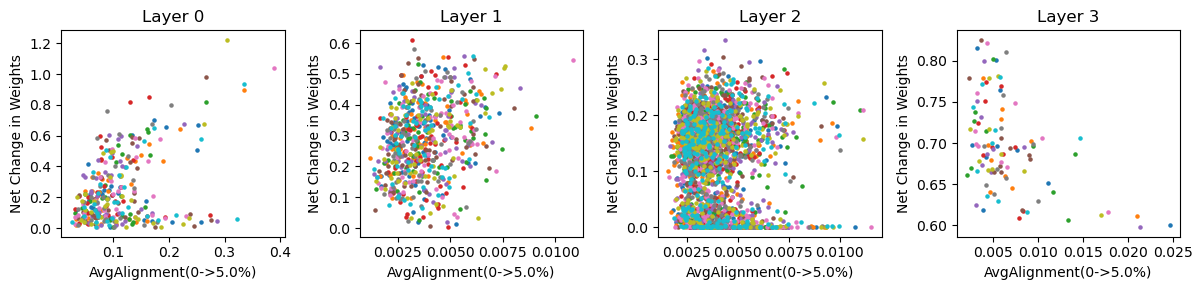

In [ ]:
# Now, compare similarity with change in weights for each layer
avgUntil = 0.05
avgPoints = int(alignLayer0[0].shape[1]*avgUntil)
netSim = lambda sim: torch.mean(sim[:,:avgPoints],dim=1)
dwAvg = 0.01
dwPoints = int(dwLayer0[0].shape[1]*avgUntil)
netDW = lambda dw: torch.mean(dw[:,-dwPoints:],dim=1)

fig,ax = plt.subplots(1,4,figsize=(12,3))
for sim,dw in zip(alignLayer0,dwLayer0):
    ax[0].scatter(netSim(sim),netDW(dw),s=5)
ax[0].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[0].set_ylabel('Net Change in Weights')
ax[0].set_title('Layer 0')

for sim,dw in zip(alignLayer1,dwLayer1):
    ax[1].scatter(netSim(sim),netDW(dw),s=5)
ax[1].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[1].set_ylabel('Net Change in Weights')
ax[1].set_title('Layer 1')

for sim,dw in zip(alignLayer2,dwLayer2):
    ax[2].scatter(netSim(sim),netDW(dw),s=5)
ax[2].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[2].set_ylabel('Net Change in Weights')
ax[2].set_title('Layer 2')

for sim,dw in zip(alignLayer3,dwLayer3):
    ax[3].scatter(netSim(sim),netDW(dw),s=5)
ax[3].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[3].set_ylabel('Net Change in Weights')
ax[3].set_title('Layer 3')

plt.tight_layout()